In [ ]:
# Launch download of image files from URL if Example_data folder is not already present.
import requests
import os
import zipfile

current=os.getcwd()

url = r'https://github.com/FLClab/2-Species-SPLIT-STED/raw/refs/heads/main/Unmixing/Example_data.zip'

output =os.path.join(current,"Example_data.zip")
output_unzip =os.path.join(current,"Example_data")

if not os.path.isfile(output):
    r = requests.get(url)
    with open(output, 'wb') as f:
        f.write(r.content)
if not os.path.isdir(output_unzip):
    with zipfile.ZipFile(output,"r") as zip_ref:
        zip_ref.extractall(output_unzip)



Current directory: c:\Users\ANDES399\Documents\GitHub\2-Species-SPLIT-STED\Unmixing


Import Python packages, define functions for display of color-coded phasor legend

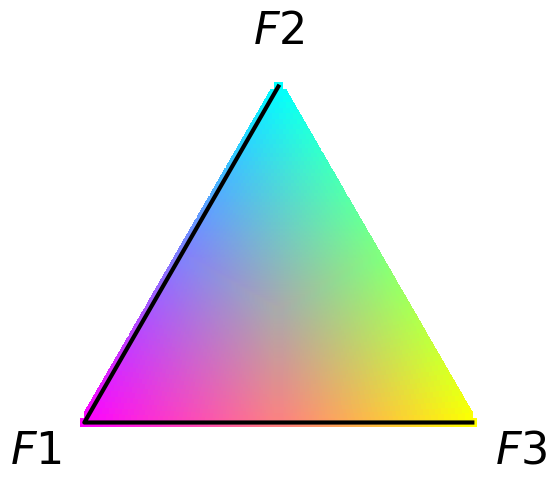

In [4]:

import tifffile
import numpy
import matplotlib.pyplot as pyplot
import pandas 
import os
from sklearn.cluster import KMeans
from skspatial.objects import Circle
from skspatial.objects import Line
from skspatial.plotting import plot_2d
from sys import path as path1;
Functionspath=os.path.join(os.path.dirname(os.getcwd()), "Functions")
path1.append(Functionspath)
from tiffwrapper import make_composite,imsave,LifetimeOverlayer
from Main_functions import (line_equation, to_polar_coord, polar_to_cart, get_foreground,load_image,select_channel)
from Phasor_functions import Median_Phasor,unmix3species

numpy.seterr(invalid="ignore") #to avoid warning when dividing by zero
def abc_to_rgb(A=0.0,B=0.0,C=0.0):
# Map values A, B, C (all in domain [0,1]) to
# suitable red, green, blue values.
    return (min(B+C,1.0),min(A+C,1.0),min(A+B,1.0))
def plot_legend():
    ''' Plots a legend for the colour scheme
    given by abc_to_rgb. Includes some code adapted
    from http://stackoverflow.com/a/6076050/637562'''

    # Basis vectors for triangle
    basis = numpy.array([[0.0, 1.0], [-1.5/numpy.sqrt(3), -0.5],[1.5/numpy.sqrt(3), -0.5]])

    fig = pyplot.figure()
    ax = fig.add_subplot(111,aspect='equal')

    # Plot points
    a, b, c = numpy.mgrid[0.0:1.0:50j, 0.0:1.0:50j, 0.0:1.0:50j]
    a, b, c = a.flatten(), b.flatten(), c.flatten()

    abc = numpy.dstack((a,b,c))[0]
    #abc = filter(lambda x: x[0]+x[1]+x[2]==1, abc) # remove points outside triangle
    abc = list(map(lambda x: x/sum(x), abc)) # or just make sure points lie inside triangle ...

    data = numpy.dot(abc, basis)
    colours = [abc_to_rgb(A=point[0],B=point[1],C=point[2]) for point in abc]

    ax.scatter(data[:,0], data[:,1],marker=',',edgecolors='none',facecolors=colours,rasterized=True)

    # Plot triangle
    ax.plot([basis[_,0] for _ in range(3)],[basis[_,1] for _ in range(3)],**{'color':'black','linewidth':3})

    # Plot labels at vertices
    offset = 0.25
    fontsize = 32
    ax.text(basis[0,0]*(1+offset), basis[0,1]*(1+offset), '$F2$', horizontalalignment='center',
            verticalalignment='center', fontsize=fontsize)
    ax.text(basis[1,0]*(1+offset), basis[1,1]*(1+offset), '$F1$', horizontalalignment='center',
            verticalalignment='center', fontsize=fontsize)
    ax.text(basis[2,0]*(1+offset), basis[2,1]*(1+offset), '$F3$', horizontalalignment='center',
            verticalalignment='center', fontsize=fontsize)    

    ax.set_frame_on(False)
    ax.set_xticks(())
    ax.set_yticks(())
    pyplot.show()

plot_legend()

In [5]:
# ------------------ Default Input variables ----------------
params_dict = {
    # Parameter in option in the matlab code
    #    "Tg" : 6, #% 'First frame to sum:'
    "Nb_to_sum": 250,  # The Tg infered from this variable override Tg
    "smooth_factor":0.2,  # % 'Smoothing factor:'
    "im_smooth_cycles": 0,  # % 'Smoothing cycles image:'
    "phasor_smooth_cycles": 1,  # % 'Smoothing cycles phasor:'
    "foreground_threshold": 10,
    "tau_exc": numpy.inf,  # % 'Tau_exc'
    "intercept_at_origin": False,  # % 'Fix Intercept at origin'

    # Parameters that are calculated in th matlab code but that could be modified manually
    "M0": None,
    "Min": None,

    # Paramaters that are fixed in the matlab code
    "m0": 1,
    "harm1": 1,  # MATLAB code: harm1=1+2*(h1-1), where h1=1
    "klog": 4,
}

#Control images dye 1
f1="Example_data/alphaTubulin_AF647_STEDPowerBleach_5to20_1_18_5percentSTED.tiff"
f2="Example_data/alphaTubulin_AF647_STEDPowerBleach_5to20_1_18_5percentSTED.tiff"
f3= "Example_data/alphaTubulin_AF647_STEDPowerBleach_5to20_1_19_10percentSTED.tiff"
f4="Example_data/alphaTubulin_AF647_STEDPowerBleach_5to20_1_6_15percentSTED.tiff"
#Control images dye 2
f5="Example_data/rab_Bassoon_STAR635P_STEDPowerBleach_5to20_3_5_5percentSTED.tiff"
f6="Example_data/rab_Bassoon_STAR635P_STEDPowerBleach_5to20_3_5_5percentSTED.tiff"
f7="Example_data/rab_Bassoon_STAR635P_STEDPowerBleach_5to20_3_0_10percentSTED.tiff"
f8="Example_data/rab_Bassoon_STAR635P_STEDPowerBleach_5to20_3_1_15percentSTED.tiff"
#Mixed images
fm1="Example_data/alphaTubulin_AF647_Bassoon_STAR635P_STEDPowerBleach_5to20_1_10_10percentSTED.tiff"
fm2="Example_data/alphaTubulin_AF647_Bassoon_STAR635P_STEDPowerBleach_5to20_1_1_10percentSTED.tiff"
#List of filenames
filenamescontrol = [f1,f2,f3,f4,f5,f6,f7,f8]
mixedimages=[fm1,fm2]


(250, 640, 552)
0 87
Example_data/alphaTubulin_AF647_STEDPowerBleach_5to20_1_18_5percentSTED.tiff (640, 552, 250)
(250, 640, 552)
0 114
Example_data/alphaTubulin_AF647_STEDPowerBleach_5to20_1_18_5percentSTED.tiff (640, 552, 250)
(250, 556, 568)
0 80
Example_data/alphaTubulin_AF647_STEDPowerBleach_5to20_1_19_10percentSTED.tiff (556, 568, 250)
(250, 524, 288)
0 60
Example_data/alphaTubulin_AF647_STEDPowerBleach_5to20_1_6_15percentSTED.tiff (524, 288, 250)
(250, 572, 764)
0 22
Example_data/rab_Bassoon_STAR635P_STEDPowerBleach_5to20_3_5_5percentSTED.tiff (572, 764, 250)
(250, 572, 764)
0 31
Example_data/rab_Bassoon_STAR635P_STEDPowerBleach_5to20_3_5_5percentSTED.tiff (572, 764, 250)
(250, 860, 464)
0 23
Example_data/rab_Bassoon_STAR635P_STEDPowerBleach_5to20_3_0_10percentSTED.tiff (860, 464, 250)
(250, 940, 460)
0 16
Example_data/rab_Bassoon_STAR635P_STEDPowerBleach_5to20_3_1_15percentSTED.tiff (940, 460, 250)


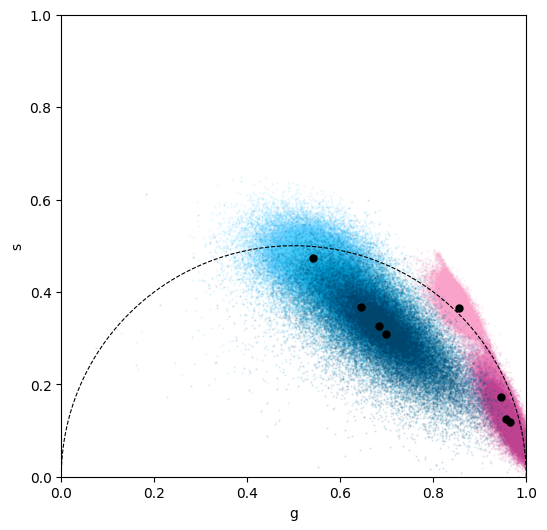

In [6]:
# ------------------ Load control images and calculate triangle coordinates in phasor space ----------------
fig4,ax_scatter = pyplot.subplots(figsize=(6,6))
ax_scatter.set_xlim(0, 1)
ax_scatter.set_ylim(0, 1)

ax_scatter.set_xlabel('g')
ax_scatter.set_ylabel('s')
edge = numpy.linspace(start=0, stop=15, num=200)
theta = numpy.linspace(0, numpy.pi, 100)
r = 0.5
x1 = r*numpy.cos(theta) + 0.5
x2 = r*numpy.sin(theta)
ax_scatter.plot(x1,x2, color = "black", ls = "--",linewidth=0.8)
#colors=['lightskyblue', 'deepskyblue','blue','mediumblue',"pink","lightpink",'lightcoral','indianred','springgreen']
labels=["Confocal","STED 10%","STED 20%","STED 30%","Confocal","STED 10%","STED 20%","STED 30%",'Mixture STED']
colors=["#f9a3cbff","#ef87beff","#e569b3ff","#bf4290ff","#55d0ffff","#00acdfff","#0080bfff","#00456bff"]
keys=[0,1,1,1,0,1,1,1,1]
CoM_x, CoM_y = [], []
for i, msr in enumerate(filenamescontrol) :
    df = pandas.DataFrame(columns=['x','y'])
    dg = pandas.DataFrame(columns=['g', 's'])
    imagemsr = load_image(msr)
    #imagemsr=imagemsr-2**15
    
    image1=select_channel(imagemsr,keys[i])
    print(numpy.min(image1),numpy.max(image1))
    print(msr, image1.shape)
    imsum = image1[:,:,10:111].sum(axis=2)
    imsum = imsum.astype('int16')
    seuil = get_foreground(imsum)
    params_dict["foreground_threshold"] = seuil
    params_dict["Nb_to_sum"] = image1.shape[2]
    
    x,y,g_smoothed,s_smoothed, original_idxes= Median_Phasor(image1, params_dict, **params_dict, show_plots=False)
    df['x']=x.flatten()
    df['y']=y.flatten()
    m, phi = to_polar_coord(df['x'], df['y'])
    g,s =polar_to_cart(m, phi)
    dg['g'], dg['s'] = g, s
    kmeans = KMeans(n_clusters = 1, init = 'k-means++', random_state = 42)
    y_kmeans = kmeans.fit_predict(dg)
    CoM_x.extend(kmeans.cluster_centers_[:, 0][:].tolist())
    CoM_y.extend(kmeans.cluster_centers_[:, 1][:].tolist())
    a=ax_scatter.scatter(g, s, s=0.5, c=colors[i], alpha=0.10,label=labels[i],rasterized=True)
ax_scatter.scatter(CoM_x, CoM_y, s=25, c="k")



pyplot.show()

I'm outside the circle, coming in!
I'm in the negatives, coming up!
POINTS [0.84873582 0.35830619] [0.54420968 0.49804167] [0.99479294 0.        ]


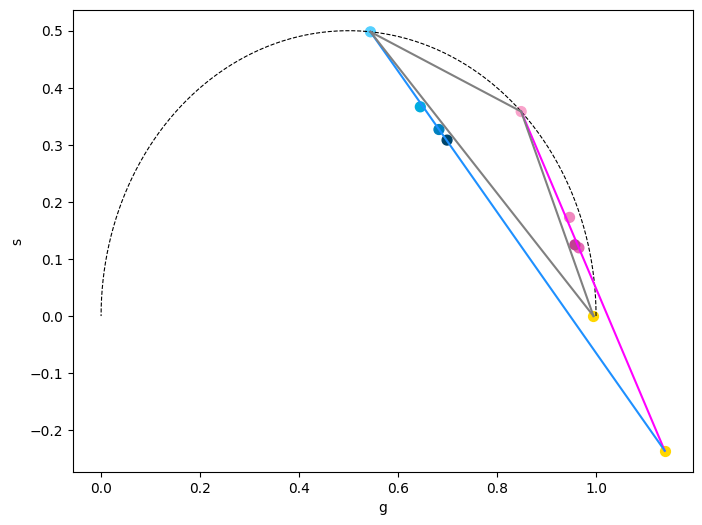

In [8]:
fig4,ax_scatter = pyplot.subplots(figsize=(8,6))
#ax_scatter.set_xlim(0, 1)
#ax_scatter.set_ylim(0, 1)

ax_scatter.set_xlabel('g')
ax_scatter.set_ylabel('s')
edge = numpy.linspace(start=0, stop=15, num=200)
theta = numpy.linspace(0, numpy.pi, 100)
r = 0.5
x1 = r*numpy.cos(theta) + 0.5
x2 = r*numpy.sin(theta)
ax_scatter.plot(x1,x2, color = "black", ls = "--",linewidth=0.8)
colors=["#f9a3cbff","#ef87beff","#e569b3ff","#bf4290ff","#55d0ffff","#00acdfff","#0080bfff","#00456bff"]


xaxis = numpy.linspace(0, 1.5, 100)
norm = numpy.sqrt((CoM_x[0] - 0.5) ** 2 + (CoM_y[0] ** 2))
Pn_x = 0.5 + (r * (CoM_x[0] - 0.5) / norm)
Pn_y = 0 + r * (CoM_y[0] - 0) / norm
P_n = numpy.array([Pn_x, Pn_y])
norm = numpy.sqrt((CoM_x[4] - 0.5) ** 2 + (CoM_y[4] ** 2))
P2_x = 0.5 + (r * (CoM_x[4] - 0.5) / norm)
P2_y = 0 + r * (CoM_y[4] - 0) / norm
p2 = numpy.array([P2_x, P2_y])
PointsSpecies1 = numpy.stack([numpy.array([Pn_x, Pn_y]), numpy.array([CoM_x[1], CoM_y[1]]), numpy.array([CoM_x[2], CoM_y[2]]),
    numpy.array([CoM_x[3], CoM_y[3]])])
PointsSpecies2 = numpy.stack([numpy.array([P2_x, P2_y]), numpy.array([CoM_x[5], CoM_y[5]]), numpy.array([CoM_x[6], CoM_y[6]]),
    numpy.array([CoM_x[7], CoM_y[7]])])

coeffs1 = numpy.polyfit([Pn_x, CoM_x[1], CoM_x[2], CoM_x[3]], [Pn_y, CoM_y[1], CoM_y[2], CoM_y[3]], 1)
coeffs2 = numpy.polyfit([P2_x, CoM_x[5], CoM_x[6], CoM_x[7]], [P2_y, CoM_y[5], CoM_y[6], CoM_y[7]], 1)
y1 = coeffs1[0] * xaxis + coeffs1[1]
y2 = coeffs2[0] * xaxis + coeffs2[1]
det = coeffs2[0] - coeffs1[0]
x = (coeffs1[1] - coeffs2[1]) / det
y = (coeffs2[0] * coeffs1[1] - coeffs1[0] * coeffs2[1]) / det

p0 = numpy.array([x, y])

p0pnline = ax_scatter.plot([Pn_x, p0[0]], [Pn_y, p0[1]], c='magenta')
p0p2line = ax_scatter.plot([P2_x, p0[0]], [P2_y, p0[1]], c='dodgerblue')
p0scatter = ax_scatter.scatter(p0[0], p0[1], s=50, c='gold')
circ = Circle((0.5, 0), radius=0.5)
check = circ.contains_point([x, y])
if check == False:  # If intersection point is outside the circle, find intersection with circle
    print("I'm outside the circle, coming in!")
    circle = Circle([0.5, 0], 0.5)
    line1 = Line.from_points([Pn_x, Pn_y], [x, y])
    line2 = Line.from_points([P2_x, P2_y], [x, y])
    point_a, point_b = circle.intersect_line(line1)
    point_c, point_d = circle.intersect_line(line2)
    p0 = numpy.mean(numpy.array([point_a, point_c]), axis=0)
    x = p0[0]
    y = p0[1]
if y < 0:  # If intersection point is under the semi-circle, find intersection with x-axis
    print("I'm in the negatives, coming up!")
    line1 = Line.from_points([Pn_x, Pn_y], [x, y])
    line2 = Line.from_points([P2_x, P2_y], [x, y])
    line3 = Line.from_points([0, 0], [1,0])
    point_a = line3.intersect_line(line1)
    point_b = line3.intersect_line(line2)
    p0 = numpy.mean(numpy.array([point_a, point_b]), axis=0)
    x = p0[0]
    y = p0[1]
print("POINTS", P_n, p2, p0)
#pnscatter = ax_scatter.scatter(Pn_x, Pn_y, s=50, c='gold')
#p2scatter = ax_scatter.scatter(P2_x, P2_y, s=50, c='gold')
p0scatter = ax_scatter.scatter(p0[0], p0[1], s=50, c='gold')
p0pnline = ax_scatter.plot([Pn_x, p0[0]], [Pn_y, p0[1]], c='grey')
p2pnline = ax_scatter.plot([Pn_x, P2_x], [Pn_y, P2_y], c='grey')
p0p2line = ax_scatter.plot([P2_x, p0[0]], [P2_y, p0[1]], c='grey')
centroidscatter1=ax_scatter.scatter(PointsSpecies1[:,0],PointsSpecies1[:,1],s=50,c=colors[0:4])
centroidscatter2 = ax_scatter.scatter(PointsSpecies2[:,0],PointsSpecies2[:,1], s=50,c=colors[4:])

fig4.savefig("Phasor_plot.pdf", transparent=True,bbox_inches='tight')
pyplot.show()

POINTS [0.84873582 0.35830619] [0.54420968 0.49804167] [0.99479294 0.        ]
***********************************************************
Working on image number  1  out of  2
***********************************************************
Example_data/alphaTubulin_AF647_Bassoon_STAR635P_STEDPowerBleach_5to20_1_10_10percentSTED.tiff
(250, 568, 616)
Example_data/rab_Bassoon_STAR635P_STEDPowerBleach_5to20_3_1_15percentSTED.tiff (568, 616, 250)
(568, 616, 250)
foreground_threshold= 5
p3 (154543, 2)
compl_check 0.9999999999999998 1.0 1.0000000000000002
Solve (3, 154543) 0.0 1.0
F1 0.0 1.0
F2 0.0 1.0
F3 0.0 1.0


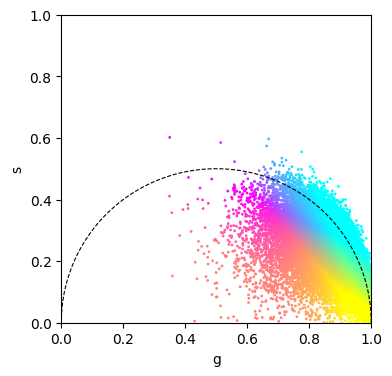

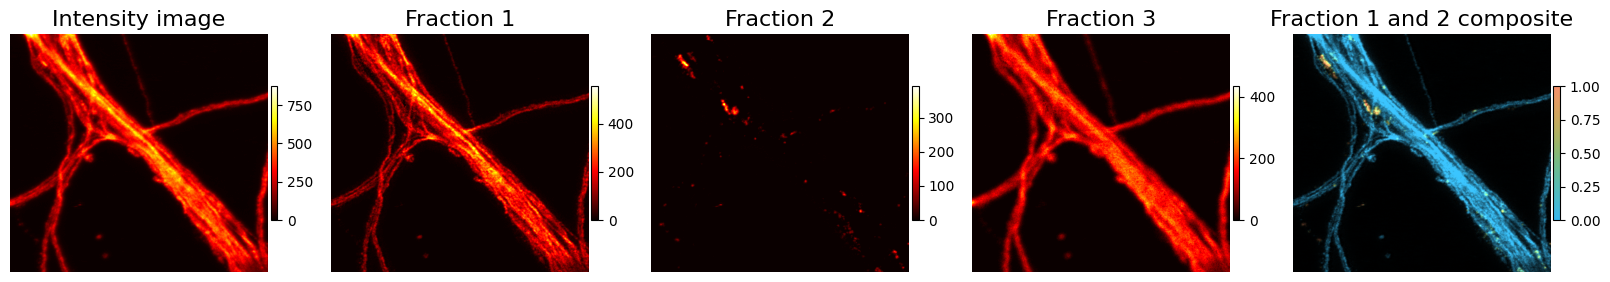

***********************************************************
Working on image number  2  out of  2
***********************************************************
Example_data/alphaTubulin_AF647_Bassoon_STAR635P_STEDPowerBleach_5to20_1_1_10percentSTED.tiff
(250, 548, 536)
Example_data/rab_Bassoon_STAR635P_STEDPowerBleach_5to20_3_1_15percentSTED.tiff (548, 536, 250)
(548, 536, 250)
foreground_threshold= 5
p3 (215038, 2)
compl_check 0.9999999999999998 1.0 1.0000000000000002
Solve (3, 215038) 0.0 1.0
F1 0.0 1.0
F2 0.0 1.0
F3 0.0 1.0


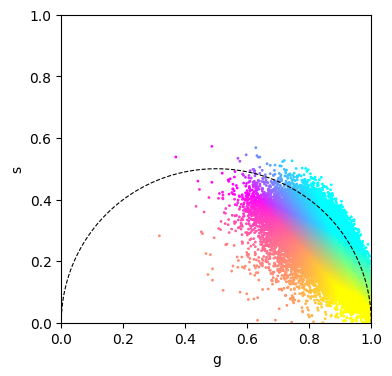

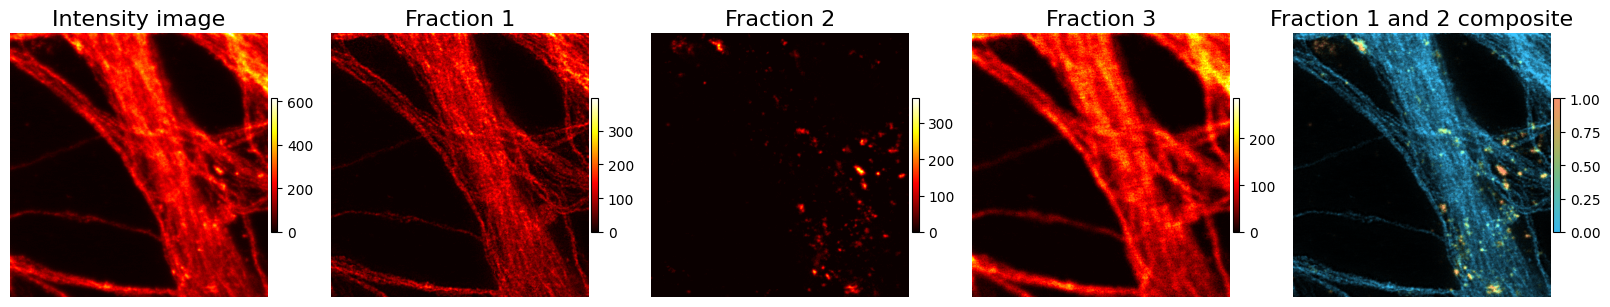

In [ ]:
# ------------------ Unmixing mixed images ----------------
for m,mixedimage in enumerate(mixedimages):

    d_melange = pandas.DataFrame(columns=['g', 's'])
    df = pandas.DataFrame(columns=['x', 'y'])
    dg = pandas.DataFrame(columns=['g', 's'])
    print("***********************************************************")
    print("Working on image number ",m+1," out of ",len(mixedimages))
    print("***********************************************************")

    print(mixedimage)
    imagemixed = load_image(mixedimage)
    #image1=image1-2**15
    image1=select_channel(imagemixed,keys[-1])
    print(msr, image1.shape)
    print(image1.shape)
    imsum = image1[:,:,10:111].sum(axis=2)
    imsum = imsum.astype('int16')

    seuil = 5
    #seuil = get_foreground(imsum)
    params_dict["foreground_threshold"] = seuil
    params_dict["Nb_to_sum"] = image1.shape[2]
    print("foreground_threshold=", params_dict["foreground_threshold"])

    x, y, g_smoothed, s_smoothed, original_idxes = Median_Phasor(image1, params_dict, **params_dict,
                                                                show_plots=False)
    df['x'] = x.flatten()
    df['y'] = y.flatten()
    m, phi = to_polar_coord(df['x'], df['y'])
    g, s = polar_to_cart(m, phi)
    dg['g'], dg['s'] = g, s
    d_melange['g'], d_melange['s'] = g, s
    kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
    y_kmeans = kmeans.fit_predict(dg)

    p3 = d_melange[['g', 's']].to_numpy() #phasor to unmix
    print("p3",p3.shape)

    imsum_flat_lin1, imsum_flat_lin2, imsum_flat_lin3, Solve = unmix3species(p3, original_idxes, image1, P_n, p2,p0)
    #imsum_flat_lin1, imsum_flat_lin2, imsum_flat_lin3, Solve =unmix3species_norescale(p3, original_idxes, image1, P_n, p2,p0)

    print('F1',imsum_flat_lin1.min(),imsum_flat_lin1.max())
    print('F2',imsum_flat_lin2.min(),imsum_flat_lin2.max())
    print('F3',imsum_flat_lin3.min(),imsum_flat_lin3.max())

    fig4,ax_scatter = pyplot.subplots(figsize=(4,4))
    ax_scatter.set_xlim(0, 1)
    ax_scatter.set_ylim(0, 1)

    ax_scatter.set_xlabel('g')
    ax_scatter.set_ylabel('s')
    edge = numpy.linspace(start=0, stop=15, num=200)
    theta = numpy.linspace(0, numpy.pi, 100)
    r = 0.5
    x1 = r*numpy.cos(theta) + 0.5
    x2 = r*numpy.sin(theta)
    ax_scatter.plot(x1,x2, color = "black", ls = "--",linewidth=0.8)
    colours = [abc_to_rgb(A=point[0],B=point[1],C=point[2]) for point in numpy.transpose(Solve)]
    mixphasor = ax_scatter.scatter(p3[:,0],p3[:,1],s=1,facecolors=colours,rasterized=True)

    imsum_flat_lin3[numpy.isinf(imsum_flat_lin3)] = 0
    imsum_flat_lin3[numpy.isnan(imsum_flat_lin3)] = 0
    imsum_flat_lin3 = numpy.where(imsum_flat_lin3 < 0, 0, imsum_flat_lin3)
    imsum_flat_lin3 = numpy.where(imsum_flat_lin3 > 1, 1, imsum_flat_lin3)
    q = 1 - imsum_flat_lin3
    imsum_flat_bi = imsum_flat_lin2 / q
    imsum_flat_bi[numpy.isinf(imsum_flat_bi)] = 0
    imsum_flat_bi[numpy.isnan(imsum_flat_bi)] = 0
    imsum_flat_bi = numpy.where(imsum_flat_bi < 0, 0, imsum_flat_bi)
    imsum_flat_bi = numpy.where(imsum_flat_bi > 1, 1, imsum_flat_bi)

    imsum_flat_bi1 = imsum_flat_lin1 / q
    imsum_flat_bi1[numpy.isinf(imsum_flat_bi1)] = 0
    imsum_flat_bi1[numpy.isnan(imsum_flat_bi1)] = 0
    imsum_flat_bi1 = numpy.where(imsum_flat_bi1 < 0, 0, imsum_flat_bi1)
    imsum_flat_bi1 = numpy.where(imsum_flat_bi1 > 1, 1, imsum_flat_bi1)

    

    fraction1 = imsum_flat_bi.copy()
    fraction2 = imsum_flat_bi1.copy()
    fraction3=imsum_flat_lin3.copy()
    fraction3 *= imsum
    difference = imsum - fraction3
    fraction1 *= difference
    fraction2 *= difference



    fig_im3, ax_im3 = pyplot.subplots(ncols=5,nrows=1,figsize=(20,6))
    ax_im3[0].axis('off')
    ax_im3[1].axis('off')
    ax_im3[2].axis('off')
    ax_im3[3].axis('off')
    ax_im3[4].axis('off')
    ax_im3[0].set_title('Intensity image', fontsize=16)
    ax_im3[1].set_title('Fraction 1', fontsize=16)
    ax_im3[2].set_title('Fraction 2', fontsize=16)
    ax_im3[3].set_title('Fraction 3', fontsize=16)
    ax_im3[4].set_title('Fraction 1 and 2 composite', fontsize=16)
    imsum_disp =ax_im3[0].imshow(imsum, cmap='hot')
    imsum_flat3 =ax_im3[1].imshow(fraction2, cmap='hot')
    imsum_flat5 =ax_im3[2].imshow(fraction1, cmap='hot')
    imsum_flat6 =ax_im3[3].imshow(fraction3, cmap='hot')

    cbar =fig_im3.colorbar(imsum_disp,ax=ax_im3[0], fraction=0.025, pad=0.01)
    #cbar.set_label("Intensity", fontsize=12)
    cbar =fig_im3.colorbar(imsum_flat3,ax=ax_im3[1], fraction=0.025, pad=0.01)
    #cbar.set_label("Intensity", fontsize=12)
    cbar2 =fig_im3.colorbar(imsum_flat5,ax=ax_im3[2], fraction=0.025, pad=0.01)
    #cbar2.set_label("Intensity", fontsize=12)
    cbar3 =fig_im3.colorbar(imsum_flat6,ax=ax_im3[3], fraction=0.025, pad=0.01)
    #cbar3.set_label("Intensity", fontsize=12)


    #imsum = indexes2intensity5(original_idxes, imsum, t2[0,:])
    overlayer = LifetimeOverlayer(imsum_flat_bi, difference/difference.max(), cname="CET-I1")
    lifetime_rgb, cmap = overlayer.get_overlay(
        lifetime_minmax=(0., 1),
        intensity_minmax=(0, 0.5) # inTensity saturated to get more bright regions
                )

    imsum_flattt =ax_im3[4].imshow(lifetime_rgb)
    cbar4 = fig_im3.colorbar(cmap,ax=ax_im3[4],fraction=0.025, pad=0.01)

    imagecomp = numpy.dstack((fraction1,fraction2))
    imagecomp = numpy.moveaxis(imagecomp, 2, 0)
    pyplot.show()

